In [1]:
%load_ext autoreload
%autoreload 2

%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


from zo_optimizer import ZOOptimizer
from meZO.meZO import meZOOptimizer
from meZO.me_linear import meLinear

# MNIST dataset
from torchvision import datasets, transforms

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
def compute_loss(model, data, target):
    output = model(data)
    loss = F.cross_entropy(output, target)
    return loss


class meNet(nn.Module):
    def __init__(self, k):
        super(meNet, self).__init__()
        self.fc1 = meLinear(28 * 28, 128, k, unified=True)
        self.fc2 = meLinear(128, 10, k, unified=True)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True
    , transform=transforms.ToTensor()
)
from torch.utils.data import DataLoader
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

device = "mps"
num_epochs = 5
# k = 1000
q = 200
mu = 0.001




trials = 10
k_losses = []
for k in [10, 20, 40, 80, 160, 320, 640, 1280, 2560]:
    losses_trials = []
    for i in range(trials):
        model = meNet(k).to(device)
        model.train()
        zo = meZOOptimizer(model, compute_loss, q, mu)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        losses = []
        for epoch in range(num_epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                loss = zo.loss_and_grad(model, data, target)

                optimizer.step()

                losses.append(loss.item())

                if batch_idx % 100 == 0:
                    print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

        losses_trials.append(losses)
        print(f"Trial {i+1}/{trials} completed.")
    k_losses.append(losses_trials)

/Users/rwgao/projects/zo_optimizer/meZO/me_linear.py:31: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta = 1, Number alpha = 1) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
  y.addmm_(0, 1, x, w)
/Users/rwgao/projects/zo_optimizer/meZO/me_linear.py:53: UserWarning: The operator 'aten::index_copy.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)
  dw = w.new(w.size()).zero_().index_copy_(


Epoch 0, Batch 0, Loss: 2.6105737686157227
Epoch 0, Batch 100, Loss: 1.8616704940795898
Epoch 0, Batch 200, Loss: 1.4142858982086182
Epoch 0, Batch 300, Loss: 1.0962026119232178
Epoch 0, Batch 400, Loss: 1.0815811157226562
Epoch 0, Batch 500, Loss: 0.666472315788269
Epoch 0, Batch 600, Loss: 0.6574393510818481
Epoch 0, Batch 700, Loss: 0.5869513750076294
Epoch 0, Batch 800, Loss: 0.508173942565918
Epoch 0, Batch 900, Loss: 0.6118425726890564
Epoch 1, Batch 0, Loss: 0.4156755208969116
Epoch 1, Batch 100, Loss: 0.4802614748477936
Epoch 1, Batch 200, Loss: 0.34843164682388306


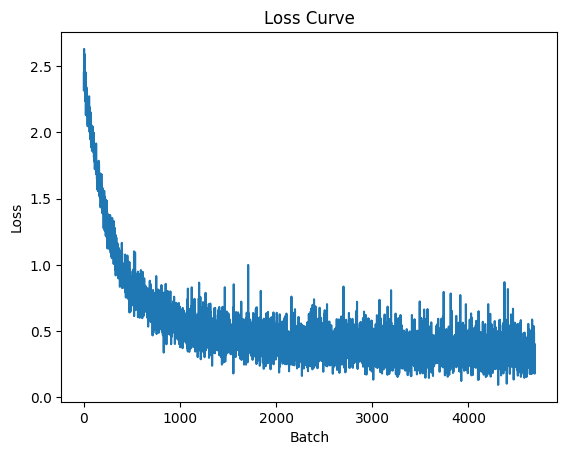

In [ ]:
# Display loss curve

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()
